In [1]:
import datetime, logging, os, sys, math, random
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_addons as tfa
from keras import Sequential, layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from PIL import Image as Img

import pickle 
import albumentations as A

from ImageDataAugmentor.image_data_augmentor import *
from albumentations.core.composition import Compose, OneOf
from albumentations.core.transforms_interface import ImageOnlyTransform

devices = tf.config.list_physical_devices('GPU')
for device in devices:
   tf.config.experimental.set_memory_growth(device, True) 
print(devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd() ,"../../../../datasets/sorghum-id-fgvc-9"))+"/"

MODEL_NAME = "sorghum-id-2022-05-03-103851-EfficientNetV2L-imagenet" #### CHANGE ME
MODEL_PATH = "../models/"+MODEL_NAME+"/EfficientNetV2L-027-0.0564.h5"

test_dir = PATH+'test/'
save_dir    = '../results/sorghum/'

WIDTH = 512
HEIGHT = 512

f = open("../labels.pkl","rb")
labels = pickle.load(f)
f.close()

submission = pd.read_csv(PATH+'sample_submission.csv')

submission

,filename,cultivar
0,1000005362.png,PI_152923
1,1000099707.png,PI_152923
2,1000135300.png,PI_152923
3,1000136796.png,PI_152923
4,1000292439.png,PI_152923
...,...,...
23634,999578153.png,PI_152923
23635,999692877.png,PI_152923
23636,999756998.png,PI_152923
23637,999892248.png,PI_152923


In [3]:
def clahe(img):
    c = cv.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))  # create a clahe object
    t = np.asarray(img)                                     # convert to np array
    t = cv.cvtColor(t, cv.COLOR_BGR2HSV)                    # convert to OpenCV HSV
    t[:,:,-1] = c.apply(t[:,:,-1])                          # Apply CLAHE to the Value (greyscale) of the image
    t = cv.cvtColor(t, cv.COLOR_HSV2BGR)                    # Return to BGR OpenCV doamin
    t = Img.fromarray(t)                                    # Convert to PIL Image
    t = np.array(t)                                         # back to np array
    return t

def normalise(img):
    t = np.array(img,dtype=np.float32)/255
    return t

class CLAHE(ImageOnlyTransform):
    def apply(self, img, **params):
        return clahe(img)

class NORMALISE(ImageOnlyTransform):
    def apply(self, img, **params):
        return normalise(img)

def augment_data(phase: str):
    if phase == "train":
        return Compose([
                A.CLAHE(clip_limit=20, tile_grid_size=(16,16),p=1),
                A.RandomResizedCrop(height=HEIGHT, width=WIDTH),
                A.Flip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=0.5),
                    A.RandomGamma(p=0.5),
                ], p=0.5),
                OneOf([
                    A.Blur(p=0.1),
                    A.GaussianBlur(p=0.1),
                    A.MotionBlur(p=0.1),
                ], p=0.1),
                OneOf([
                    A.GaussNoise(p=0.1),
                    A.ISONoise(p=0.1),
                    A.GridDropout(ratio=0.5, p=0.2),
                    A.CoarseDropout(max_holes=16, min_holes=8, max_height=16,
                                    max_width=16, min_height=8, min_width=8, p=0.2)
                ], p=0.2),
                #A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
                
        ])
    else:
        return Compose([
                A.CLAHE(clip_limit=20, tile_grid_size=(16,16),p=1),
                A.Resize(height=HEIGHT, width=WIDTH),
                #A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
        ])

In [4]:
test_gen = ImageDataAugmentor(augment=augment_data("test"))
test_generator = test_gen.flow_from_dataframe(dataframe=submission,
                                              directory=test_dir,
                                              x_col='filename',
                                              y_col=None,
                                              target_size=(WIDTH,HEIGHT),
                                              color_mode='rgb',
                                              class_mode=None,
                                              batch_size=1,
                                              shuffle=False,)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST,test_generator.n,test_generator.batch_size

reconstructed_model = tf.keras.models.load_model(MODEL_PATH)

Found 23639 validated image filenames.


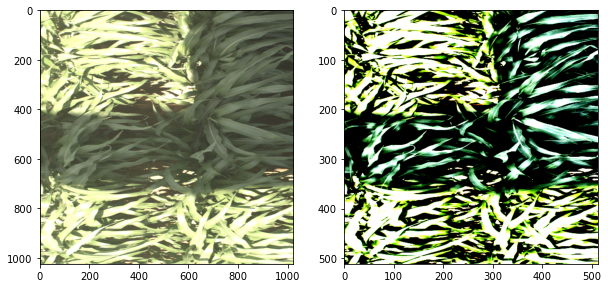

34 255
-2.0322802 2.6399999


In [86]:
image = cv2.imread("/mnt/shared/scratch/fmacfarl/datasets/sorghum-id-fgvc-9/train_images/2017-06-05__13-04-59-234.png")
#image = cv2.imread("/mnt/shared/scratch/fmacfarl/datasets/sorghum-id-fgvc-9/train_images/2017-06-30__12-38-34-583.png")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed_image = augment_data("test")(image=image)["image"]

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
plt.imshow(image)
ax = plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.show()

print(np.min(image),np.max(image))
print(np.min(transformed_image),np.max(transformed_image))

In [6]:
%time
test_generator.reset()
results = reconstructed_model.predict(test_generator,verbose=1,steps=STEP_SIZE_TEST)

predicted_class_indices=np.argmax(results,axis=1)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

CPU times: user 34 µs, sys: 20 µs, total: 54 µs
Wall time: 105 µs
23639/23639 [==============================] - 1966s 83ms/step


In [7]:
filenames=test_generator.filenames
submission=pd.DataFrame({"Filename":[filename.replace('all_classes/','')for filename in filenames],
                      "cultivar":predictions})
submission

submission_name = save_dir+'submission-EfficientNetV2L-16-2022-05-03-103851_v2.csv'
submission.to_csv(submission_name,index=False)

In [8]:
os.system('kaggle competitions submit -c sorghum-id-fgvc-9 -f '+submission_name+' -m "EfficientNetV2L using most recent weights"')

100%|██████████| 564k/564k [00:01<00:00, 301kB/s] 


Successfully submitted to Sorghum -100 Cultivar Identification - FGVC 9

0